In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from graphviz import Digraph

List of Causal Effects:

Earth quake affects monetary policy https://www.sciencedirect.com/science/article/pii/S0164070418304026

Dynamics of Tokyo Electric Power Company and the Nikkei https://www.jstor.org/stable/26418774

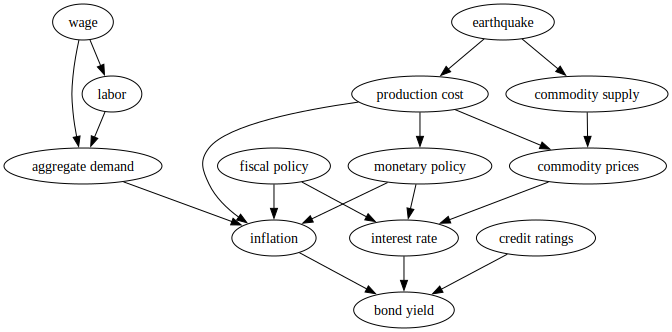

In [79]:
## TODO: make changes to the DAG
g = Digraph()
g.edge("interest rate", "bond yield")
g.edge("inflation", "bond yield")
g.edge("credit ratings", "bond yield")
g.edge("production cost", "inflation")
g.edge("aggregate demand", "inflation")
g.edge("wage", "aggregate demand")
g.edge("wage", "labor")
g.edge("labor", "aggregate demand")
g.edge("monetary policy", "interest rate")
g.edge("fiscal policy", "interest rate")
g.edge("production cost", "monetary policy")
g.edge("earthquake", "production cost")
g.edge("earthquake", "commodity supply")
g.edge("commodity supply", "commodity prices")
g.edge("production cost", "commodity prices")
g.edge("commodity prices", "interest rate")
g.edge("monetary policy", "inflation")
g.edge("fiscal policy", "inflation")
g

data sources:
prices.csv and yields.csv are taken from https://www.kaggle.com/datasets/everget/government-bonds/

In [80]:
# prices = pd.read_csv("data/prices.csv").sort_values(by='time', ascending=True)
prices = pd.read_csv("data/prices.csv").sort_values(by='time', ascending=True)
prices['datetime'] = pd.to_datetime(prices['time'], unit='ms')
prices['datetime'] = prices['datetime'].dt.strftime('%Y/%m/%d')
prices.head()

,time,AU01,AU02,AU03,AU05,AU07,AU10,AU15,AU20,AU30,...,US06M,US01,US02,US03,US05,US07,US10,US20,US30,datetime
12786,397800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/05
12785,484200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/06
12784,570600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/07
12783,657000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/08
12782,743400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/09


In [81]:
def getFirstNonZero(arr):
    i = 0
    n = len(arr)
    for i in range(n):
        if arr[i] != 0:
            return i
    return -1

def createPlot(df, countryCode, title, independent, ytms):
    fig, ax = plt.subplots()
    x = df[independent]
    for ytm in ytms:
        data = df[countryCode + ytm].to_numpy()
        idx = getFirstNonZero(data)
        ax.plot(x.to_numpy()[idx:], data[idx:], label = countryCode + ytm)
    plt.title(title)
    plt.legend()
    plt.show()

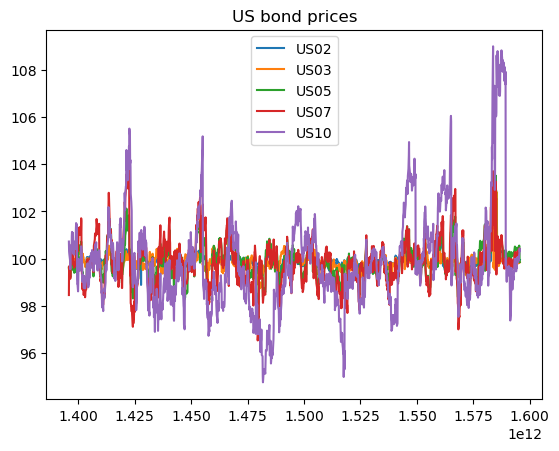

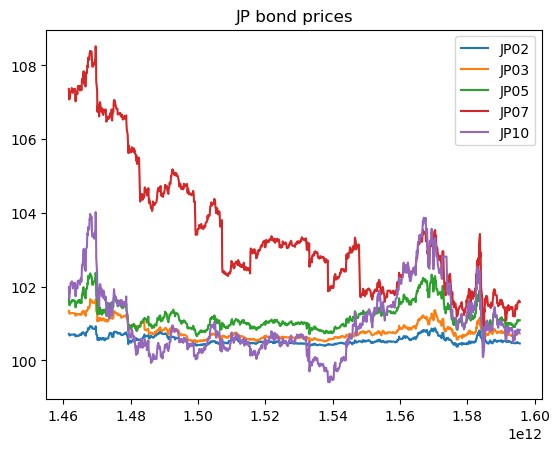

In [82]:
createPlot(prices, 'US', 'US bond prices', 'time', ['02','03','05','07','10'])
createPlot(prices, 'JP', 'JP bond prices', 'time', ['02','03','05','07','10'])

In [83]:
yields = pd.read_csv("data/yields.csv").sort_values(by='time', ascending=True)
yields['datetime'] = pd.to_datetime(yields['time'], unit='ms')
yields['datetime'] = yields['datetime'].dt.strftime('%Y/%m/%d')
yields.head()

,time,AU01,AU02,AU03,AU05,AU07,AU10,AU15,AU20,AU30,...,US06M,US01,US02,US03,US05,US07,US10,US20,US30,datetime
11962,397800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/05
11963,484200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/06
11964,570600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/07
11965,657000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/08
11966,743400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/09


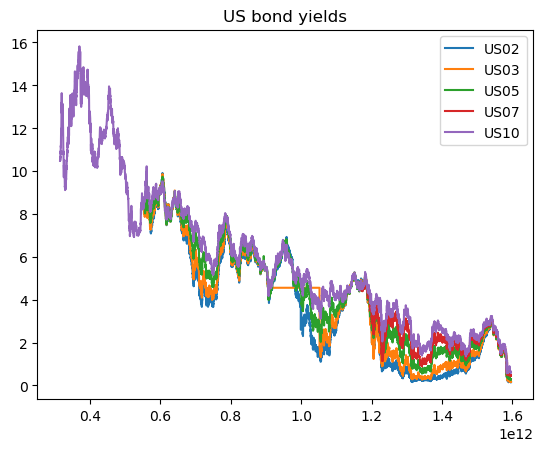

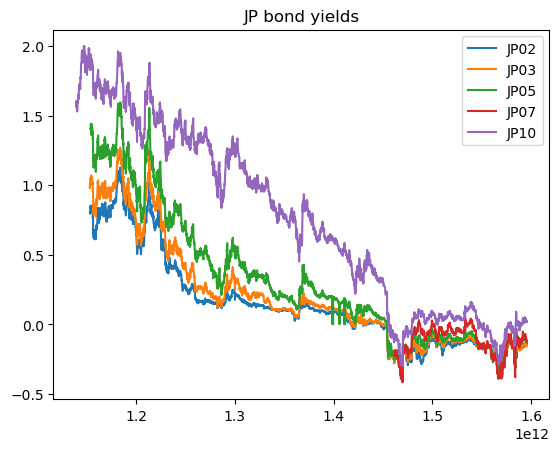

In [84]:
createPlot(yields, 'US', 'US bond yields', 'time', ['02','03','05','07','10'])
createPlot(yields, 'JP', 'JP bond yields', 'time', ['02','03','05','07','10'])